In [1]:
import os
import sys
sys.path.append(os.path.dirname(os.path.realpath('../src/models/lstm_mixture_density_model.py')))
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from lstm_mixture_density_model import tf_lstm_mixture_density_model

# Build lstm model


In [2]:
model_name = 'my_lstm_model'

input_length = 5
n_lstm_units = 32
n_layers = 1
pred_x_dim = 4
obs_x_dim = 5
n_mixtures = 3
dropout_prob = 0.1
y_dim = 8
batch_size=1
learning_rate = 0.01
start_time_sd = 0.01

with tf.device('/cpu:0'):
    lstm_DM = tf_lstm_mixture_density_model(name=model_name,
                                            input_length=input_length,
                                            n_lstm_units=n_lstm_units,
                                            n_layers=n_layers,
                                            pred_x_dim=pred_x_dim,
                                            obs_x_dim=obs_x_dim,
                                            y_dim=y_dim,
                                            batch_size=batch_size,
                                            n_loc_mixtures=n_mixtures,
                                            dropout_prob = dropout_prob,
                                            learning_rate=learning_rate,
                                            start_time_sd=start_time_sd)


# Load sample data

### Note: the data is artificially made for demonstration purpose only.

In [3]:
# We made up 5 activities with location, starting time, duration, and activity types
# The 5 activity types are home -> other -> work -> other -> home


# Activity information
location_list = np.array([[37.750460, -122.429491],
                          [37.944496, -122.351648],
                          [37.856912, -122.288567],
                          [37.754701, -122.188187],
                          [37.750460, -122.429491]])

start_time_list = np.array([[7.0], 
                            [8.4], 
                            [12.5], 
                            [16.0], 
                            [18.0]])

duration_list = np.array([[1.4], 
                          [4.1], 
                          [5.5], 
                          [2.0], 
                          [12.0]])

activity_type_list = np.array([[1, 0, 0],
                               [0, 0, 1],
                               [0, 1, 0],
                               [0, 0, 1],
                               [1, 0, 0]])

end_of_day_list = np.array([[0],
                            [0],
                            [0],
                            [0],
                            [1]])

activity_information = np.hstack((location_list, 
                                  start_time_list, 
                                  duration_list, 
                                  activity_type_list, 
                                  end_of_day_list))
activity_information = activity_information[np.newaxis, :]

# Contextual variables
dayOfWeek_list = np.array([1])
home_location_list = np.array([37.750460, -122.429491])
work_location_list = np.array([37.856912, -122.288567])

contextual_variables = np.hstack((np.array([dayOfWeek_list] * 5),
                                  np.array([home_location_list] * 5),
                                  np.array([work_location_list] * 5)))
contextual_variables = contextual_variables[np.newaxis, :]
                         
# Initilization for LSTM model
X_init = np.zeros((1, pred_x_dim))


# Normalize Data

In [4]:
# Center latitude and longitude
lat_mean = np.mean(activity_information[:, :, 0])
lon_mean = np.mean(activity_information[:, :, 1])
activity_information[:, :, 0] -= lat_mean
activity_information[:, :, 1] -= lon_mean

contextual_variables[:, :, 1] -= lat_mean
contextual_variables[:, :, 3] -= lat_mean
contextual_variables[:, :, 2] -= lon_mean
contextual_variables[:, :, 4] -= lon_mean


# Normalize latitude and longitude to -1~1
# Normalize starting time and duration to 0~1
lat_max = np.max(np.abs(activity_information[:, :, 0]))
lon_max = np.max(np.abs(activity_information[:, :, 1]))

activity_information /= np.array([lat_max, 
                                  lon_max,
                                  24.,
                                  24.,
                                  1.,
                                  1.,
                                  1.,
                                  1.])

contextual_variables /= np.array([1, 
                                  lat_max, 
                                  lon_max,
                                  lat_max, 
                                  lon_max])

# Training

In [5]:
config = tf.ConfigProto(allow_soft_placement = True)
sess = tf.Session(config = config)
sess.run(tf.global_variables_initializer())

location_sd_bias = 0.0
time_sd_bias = 0.0
pi_bias = 0.0

lstm_DM.train(X_init=X_init, 
              X_input_seq=contextual_variables,
              y=activity_information,
              epochs=5000,
              sess=sess,
              start_time_list=[start_time_list[0]/24.] ,
              per=1000,
              location_sd_bias=location_sd_bias,
              time_sd_bias=time_sd_bias,
              pi_bias=pi_bias)



Epoch: 0 Loss: 0.023646692276
Epoch: 1000 Loss: -42.8392385841
Epoch: 2000 Loss: -56.6754158497
Epoch: 3000 Loss: -64.2825565395
Epoch: 4000 Loss: -58.9427371559


# Generate Sequences

In [6]:
gen_seq, \
gen_coef, \
gen_states, \
gen_mixture_coef = lstm_DM.generate_sequence_coefficients(sess=sess,
                                                          X_init=X_init,
                                                          X_input_seq=contextual_variables,
                                                          start_time_list=[start_time_list[0]/24.],
                                                          n=200)


# Plot Sequences

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
# Scale data back 
activity_information[:, :, 0] *= lat_max
activity_information[:, :, 1] *= lon_max
activity_information[:, :, 0] += lat_mean
activity_information[:, :, 1] += lon_mean
activity_information[:, :, 2] *= 24.
activity_information[:, :, 3] *= 24.

gen_seq[:, :, 0] *= lat_max
gen_seq[:, :, 1] *= lon_max
gen_seq[:, :, 0] += lat_mean
gen_seq[:, :, 1] += lon_mean
gen_seq[:, :, 2] *= 24
gen_seq[:, :, 3] *= 24


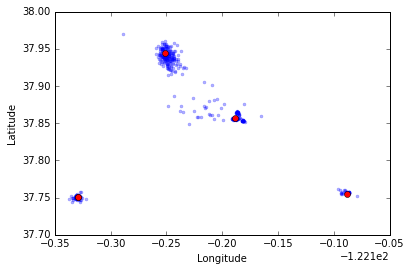

In [9]:
plt.figure()


for i in xrange(200):
    plt.plot(gen_seq[i][:,1], gen_seq[i][:,0], 'b.', alpha =0.3)

plt.plot(activity_information[0][:,1], activity_information[0][:,0], 'ro', lw=3)

plt.xlabel('Longitude')
plt.ylabel('Latitude')


(0, 24)

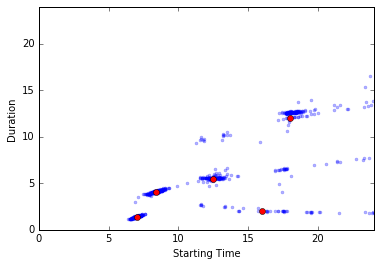

In [10]:
plt.figure()

for i in xrange(200):
    plt.plot(gen_seq[i][:,2], gen_seq[i][:,3], 'b.', alpha =0.3)

plt.plot(activity_information[0][:,2], activity_information[0][:,3], 'ro', lw=3)


plt.xlabel('Starting Time')
plt.ylabel('Duration')
plt.xlim((0, 24))
plt.ylim((0, 24))
